## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### 1.2 Imports

In [4]:
import os
import random

import albumentations as A
import importlib
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from datasets import load_dataset
from livelossplot import PlotLosses
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)
from transformers import MaskFormerConfig, MaskFormerModel
from typing import List

# Local imports
import utils.data_handler as dh
import utils.mri_plotter as mrp
import utils.metrics as metrics

# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
# Todo: delete this when the functions are finalized
importlib.reload(dh)
importlib.reload(mrp)
importlib.reload(metrics)

from utils.data_handler import DataHandler, MriType, StructuralScan
from utils.mri_plotter import MRIPlotter
np.set_printoptions(precision=16)

### 1.3 Initializations (important!)

In [5]:
# this class will handle all actions related to saving and loading files
# by default, downloads files into the runtime but saves training data to the cloud
data_handler = DataHandler()

In [6]:
# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [7]:
# specify which training directory to use
# train_dir_prefix = create_train_dir_by_date()
train_dir_prefix = 'maskformer/huafeng'
# train_dir_prefix = "maskformer/keith"

# if RETRAIN is False, load from existing model:
RETRAIN = True
LOADMODEL = True
model_file_name = "model_all_aug_20epoch_better.pt"
model_train_dir_prefix = "maskformer/huafeng"


RECALCULATE_METRICS = True
metrics_file_name = f"metrics-{str(int( time.time() ))}.joblib"
# metrics_file_name = f"metrics_val_all_15epoch.joblib"
# metrics_dir_prefix = "metrics"
metrics_dir_prefix = "maskformer/huafeng"

print("metrics_file_name: ", metrics_file_name)

metrics_file_name:  metrics-1688492726.joblib


In [8]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that director
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input("Chosen directory has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer != "YES":
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

Chosen directory has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using training_dir_prefix: maskformer/huafeng


### 1.4 General functions

In [9]:
# helper functions
def collate_fn(batch):
    return {
            "pixel_values": torch.stack([example["pixel_values"] for example in batch]),
            "pixel_mask": torch.stack([example["pixel_mask"] for example in batch]),
            "class_labels": [example["class_labels"] for example in batch],
            "mask_labels": [example["mask_labels"] for example in batch],
            "subj_no": [example["subj_no"] for example in batch],
            "file_no": [example["file_no"] for example in batch]
            }

# get mask
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

def softmax(logits):
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def softmax_2d(logits):
    e_x = np.exp(logits - np.max(logits, axis=(0, 1), keepdims=True))
    return e_x / np.sum(e_x, axis=(0, 1), keepdims=True)

In [10]:
# Reusable functions
def get_subj_ids(subj_files):
    # get unique subj train ids: [0001, 0002, 0003 ..]
    subj_ids = []
    for subj in subj_files:
        subj_id = data_handler.get_mri_subj_id(subj)
        if subj_id not in subj_ids:
            subj_ids.append(subj_id)
    return subj_ids

def get_subset_files(subj_files, subj_ids):
    # filter files within range
    subj_filenames = []
    for file_name in subj_files:
        subj_id = data_handler.get_mri_subj_id(file_name)
        subj_idx = subj_ids.index(subj_id)
        file_no = data_handler.get_mri_file_no(file_name)
        if file_no >= file_no_min and file_no < file_no_max and subj_idx >= subj_id_min and subj_idx < subj_id_max:

            # example:
            # file_name: UPENN-GBM-00006_11_FLAIR_1.nii.gz
            # result: UPENN-GBM-00006_1.nii.gz
            subj_filename = data_handler.get_mri_slice_file_name(file_name)

            # item has to be unique
            if subj_filename not in subj_filenames:
                subj_filenames.append(subj_filename)
    subj_filenames.sort()
    return subj_filenames


### 1.5 Data loaders
We define here how to organize data into the input format for maskformer

In [11]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, data_handler: DataHandler, data_identifier: MriType, data_list: List[str], processor, transform=None, augment=None):
        """
        Args:
            dataset
        """
        # valid types: MriType.TRAIN_2D, MriType.VAL_2D, MriType.TRAIN_2d_CROSS and  MriType.VAL_2D_CROSS
        self.mri_type = data_identifier

        self.processor = processor
        self.transform = transform
        self.augment = augment

        # use the Data Handler class to handle all sorts of image loading
        self.data_handler = data_handler

        # keith notes: decided to pass the list to the class instead of the filename since the training list can come from anywhere
        # we may want to train just 5 files from a list. creating a new file and storing it for every training/validation may not be ideal
        self.data_list = data_list
        self.n_data = len(self.data_list)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        # find a file corresponding to idx
        item = None
        try:
          item = self.data_list[idx]
        except IndexError:
          item = self.data_list[0]

        subj_no = item.split('.')[0].split('_')[0]
        file_no = item.split('.')[0].split('_')[1]
        # print("Subj no", subj_no)
        # print("File no", file_no)
        # load data file to image and instance_seg
        # return nifti=True to return format before converting to numpy get_fdata

        data_cur, data_cur_nifti = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type,
                                              struct_scan = StructuralScan.FLAIR, return_nifti=True)
        # print(data_cur.shape)
        n_h = data_cur_nifti.shape[0]
        n_w = data_cur_nifti.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        # convert data range from [0 1] to [0 255]
        image[:,:,0] = data_cur * 255
        # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1)
        image[:,:,1] = data_cur * 255

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1GD)
        image[:,:,2] = data_cur * 255

        # load segm file
        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, dtype="uint8")
        instance_seg =  np.zeros( (n_h, n_w), dtype='uint8')
        instance_seg[:,:] = data_cur
        # print(instance_seg.max())
        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        mapping_dict[4] = 3
        # mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply data augmentation
        if self.augment is True:

            # # Image Color Jittering
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())
            pil_image = Image.fromarray(image.astype(np.uint8))
            color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            pil_image = color_jitter(pil_image)
            image = np.array(pil_image)
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            # convert to tensors
            image = torch.from_numpy(image.astype('float'))
            instance_seg = torch.from_numpy(instance_seg)
            # print("image mean, max=",image[0,:,:].mean(), image[0,:,:].max())

            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.2:
                chance1 = random.choice([0,1,2,3,4])
                dim1 = image.shape
                # print('Original image dimension:',dim1,'choice:',chance1)
                if chance1 == 0: #upper left
                    image        =        image[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                elif chance1 == 1: #upper right
                    image        =        image[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image        =        image[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                elif chance1 == 3: #lower left
                    image        =        image[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                else: # center
                    image        =        image[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

        # apply input transforms, including resize (after cropping)
        if self.transform:
            transformed = self.transform(image=image, mask=instance_seg)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

            image, instance_seg = transformed['image'], transformed['mask']
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

        # Prepare data to fit Maskformer input
        # if class_labels.shape[0] == 1 and class_labels[0] == 0:
        #     # Some image does not have annotation (all ignored)
        #     inputs = self.processor([image], return_tensors="pt")
        #     inputs = {k:v.squeeze() for k,v in inputs.items()}
        #     inputs["class_labels"] = torch.tensor([0])
        #     inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        # else:
        #     inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        #     inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}
        inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        # add file and subj to input
        inputs["subj_no"] = subj_no
        inputs["file_no"] = file_no

        return inputs


## 2. Process 2D data

### 2.1 load and select data

In [12]:
# set directories
train_list_full = "data_train_all.txt"
val_list_full   = "data_val_all.txt"
train_list = "data_train.txt"
val_list   = "data_val.txt"

# old functionality
# ! ls $train_dir > $train_list_full
# ! ls $val_dir   > $val_list_full

#### Using below if use all data

In [13]:
# train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D_CROSS)
# train_files_unique = [data_handler.get_mri_slice_file_name(file_name) for file_name in train_2d]
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")
# data_handler.save_text(file_name = train_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in train_files_unique))


# val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D_CROSS)
# val_files_unique = [data_handler.get_mri_slice_file_name(file_name) for file_name in val_2d]
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")
# data_handler.save_text(file_name = val_list,
#                        train_dir_prefix=train_dir_prefix,
#                        data='\n'.join(str(item) for item in val_files_unique))

#### **Testing:** Using a small portion of data for efficient testing

In [14]:
# list files
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# save as text file
data_handler.save_text(file_name = train_list_full,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_2d))
data_handler.save_text(file_name = val_list_full,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_2d))

In [15]:
# selecting slice range
n_total = 146
# file_no_min = n_total//2 - 20
# file_no_max = n_total//2 + 20
file_no_min = 0
file_no_max = n_total + 1

# selecting patent id range
subj_total = 88
# subj_id_min = 0
# subj_id_max = 1
subj_id_min = 0
subj_id_max = subj_total + 1

# Define train and validation dataset
# obtain all train subject ids
subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
                                                  train_dir_prefix=train_dir_prefix)
subj_train_ids = get_subj_ids(subj_train_files)

train_files_unique_c = get_subset_files(subj_train_files, subj_train_ids)
print(f"Number of unique training samples: {len(train_files_unique_c)}")
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_files_unique_c))

# do same for validation
subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
                                                train_dir_prefix=train_dir_prefix)

subj_val_ids = get_subj_ids(subj_val_files)
val_files_unique_c = get_subset_files(subj_val_files, subj_val_ids)
print(f"Number of unique validation samples: {len(val_files_unique_c)}")
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_files_unique_c))


Number of unique training samples: 12848
Number of unique validation samples: 4380


### 2.2 Create Custom PyTorch Dataset


In [16]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [17]:
# create train/validation datasets

# use the same mean and std as training set
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# define data transoforms
train_transform = A.Compose([
    # A.Resize(width=146, height=193),
    # A.Resize(width=193, height=163),
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# TODO: delete the code that saves the list into the text file (unless there's a need for keeping a record)
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=train_dir_prefix)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=train_dir_prefix)

# create datasets
# train_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.TRAIN_2D, data_list=train_data_list, processor=processor, transform=train_transform, augment=False)
train_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.TRAIN_2D, data_list=train_data_list, processor=processor, transform=train_transform, augment=True)
val_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=MriType.VAL_2D, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)

In [18]:
# setup data loader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [19]:
# make label dictionary
id2label = dh.SEGMENTS

# replace the index 4 with 3
if 4 in id2label:
    id2label[3] = id2label[4]
    del id2label[4]

print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


### 2.3 QC dataset

In [20]:
# peek at the dataset
inputs = train_dataset[119]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
12848
tensor([0, 1, 2, 3])


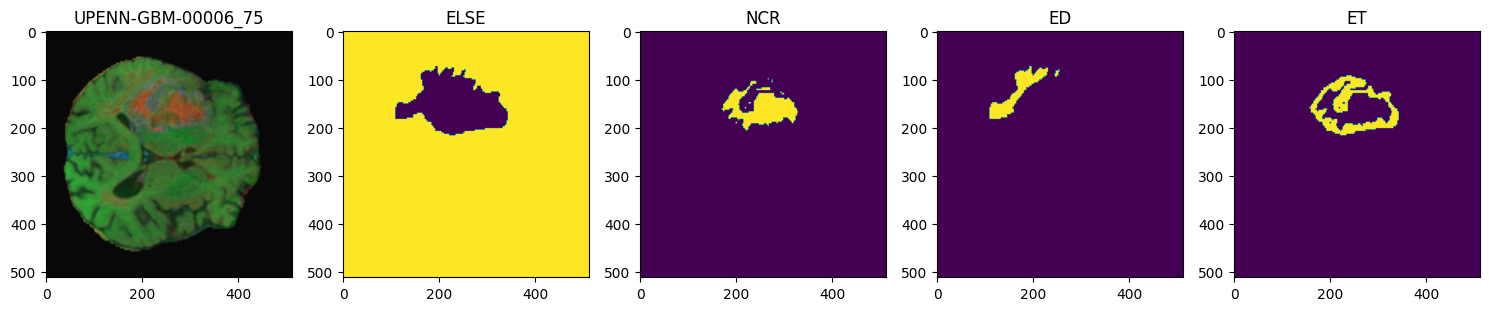

In [21]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"{inputs['subj_no']}_{inputs['file_no']}")

for mask_idx, mask in enumerate(inputs["class_labels"]):
    mask_value = mask.item()
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[mask_value]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

In [22]:
# peek at the dataset
inputs = val_dataset[119]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
4380
tensor([0, 1, 2, 3])


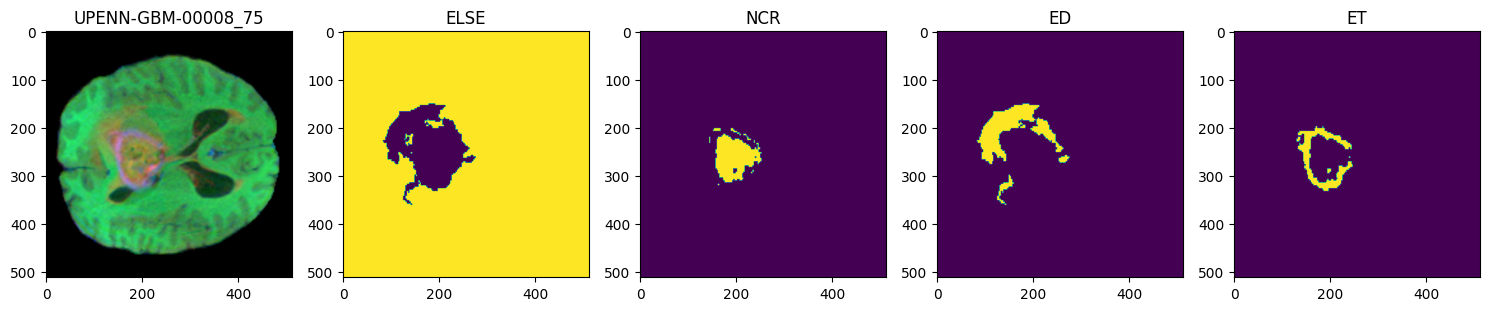

In [23]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"{inputs['subj_no']}_{inputs['file_no']}")

for mask_idx, id in enumerate(inputs["class_labels"]):
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[id.item()]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

## 3. Fine-tuning Model

### 3.1 Define the model

In [24]:
# load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# load saved model if needed

if LOADMODEL == True:
  model_steam = data_handler.load_from_stream(file_name=model_file_name, train_dir_prefix=model_train_dir_prefix)
  model = torch.load(model_steam, map_location=device)

In [26]:
# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1
# model.config.cross_entropy_weight  = 10000.0
# model.config.use_auxiliary_loss = False
# model.config.ce_weight = 10000.0

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_commit_hash": "2414a16c60f1463efcba694a0b4ff6b8a764a4cf",
  "_name_or_path": "zuppif/maskformer-swin-base-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 128,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
 

In [27]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 512, 512]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 512, 512]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 512, 512]     [2, 128, 128, 128]   86,882,424           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 128, 128, 128]   --                   4,951,808            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [86]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print('Initial Loss is:',outputs.loss.item())


pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
[torch.Size([4]), torch.Size([4])]
[torch.Size([4, 512, 512]), torch.Size([4, 512, 512])]
Initial Loss is: 0.5636104345321655


In [87]:
batch["mask_labels"][0].shape

torch.Size([4, 512, 512])

### 3.3 Train the model

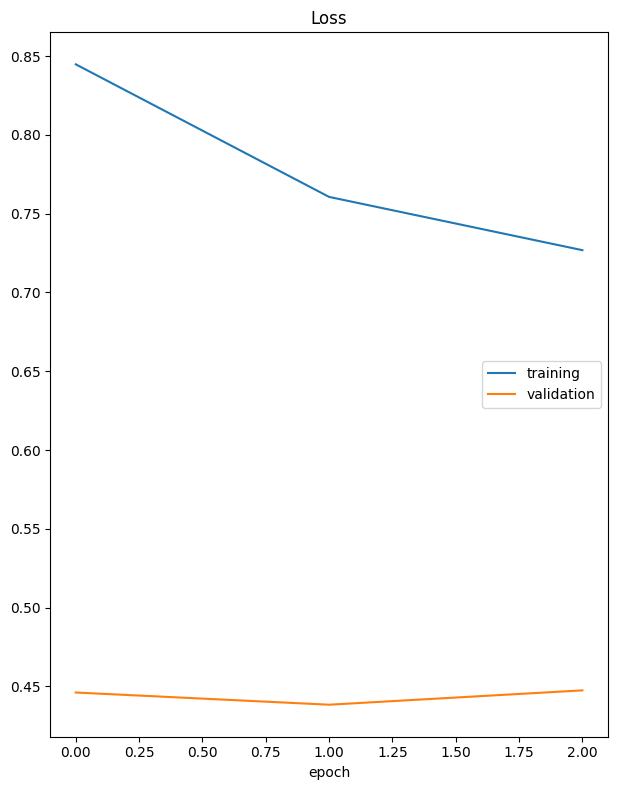

Loss
	training         	 (min:    0.727, max:    0.845, cur:    0.727)
	validation       	 (min:    0.438, max:    0.447, cur:    0.447)
Starting Epoch: 4


  0%|          | 0/6424 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-3f9ccaf46231>", line 51, in <cell line: 3>
    outputs = model(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/modeling_maskformer.py", line 1806, in forward
    outputs: MaskFormerModelOutput = self.model(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/modeling_maskformer.py", line 1596, in forward
    pixel_level_module_output = self.pixel_level_module(pixel_values, output_hidden_states)
  File "/usr/local/lib/python3.10/di

In [ ]:
# RETRAIN = True

if RETRAIN:
  # training
  liveloss = PlotLosses()

  batch_max = 100000
  loss_train = []
  loss_val = []
  min_loss = 1e9
  # mutiplier is used to scale loss values to be more readable
  loss_multiplier = 10.0

  # define number of epochs in training
  n_epoch = 5

  # saving model half way
  SAVE_INT = n_epoch // n_epoch

  # define learning rate
#   lr = 2e-5
  lr = 1e-5
#   lr = 0.5e-5

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)*loss_multiplier) )
  logs = {}
  # logs['loss'] = loss_init
  # logs['val_loss'] = loss_init

  # liveloss.update(logs)
  # liveloss.send()

  for epoch in range(1,n_epoch+1):
      print("Starting Epoch:", epoch)

      ## training loop
      running_loss = 0.0
      num_samples = 0
      model.train()
      for ibatch, batch in enumerate(tqdm(train_dataloader)):
          # run partial data based on input limit
          if ibatch < batch_max:
              # Reset the parameter gradients
              optimizer.zero_grad()

              # Forward pass
              outputs = model(
                      pixel_values=batch["pixel_values"].to(device),
                      mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                      class_labels=[labels.to(device) for labels in batch["class_labels"]],
              )

              # Backward propagation
              loss = outputs.loss * loss_multiplier
              loss.backward()

              batch_size = batch["pixel_values"].size(0)
              running_loss += loss.item()
              num_samples += batch_size
              loss_train_cur = running_loss/num_samples

              # Optimization
              optimizer.step()
          else:
              # skip where ibatch >= batch_max
              break

      # record loss at the end of each epoch
      logs['loss'] = loss_train_cur
      print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
      loss_train.append(loss_train_cur)

      ## validation loop
      running_loss = 0.0
      num_samples = 0
      model.eval()
      with torch.no_grad():
          for ibatch, batch in enumerate(tqdm(val_dataloader)):
              # run partial data based on input limit
              if ibatch < batch_max:
                  # Forward pass
                  outputs = model(
                          pixel_values=batch["pixel_values"].to(device),
                          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                          class_labels=[labels.to(device) for labels in batch["class_labels"]],
                  )

                  # loss
                  loss = outputs.loss  * loss_multiplier

                  batch_size = batch["pixel_values"].size(0)
                  running_loss += loss.item()
                  num_samples += batch_size
                  loss_val_cur = running_loss/num_samples
              else:
                  # skip where ibatch >= batch_max
                  break

      # record loss at the end of each epoch
      logs['val_loss'] = loss_val_cur
      # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
      loss_val.append(loss_val_cur)

      # if found better model, update min_loss and save model (currently using training loss)

      if min_loss > loss_val_cur:
          print("Saved model in epoch",epoch)
          # save the best model
          # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
          min_loss = loss_val_cur

      # save model regularly
      if epoch%SAVE_INT == 0:
          print("Saved model in epoch",epoch)

          # save the best model
          data_handler.save_torch_model(file_name='model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

      # Update the plot with new logging information.
      liveloss.update(logs)
      liveloss.send()

  # save loss at the end
  data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
  data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

## 4. Evaluation

### 4.1 Model prediction QC on one sample



#### 4.1.1 model prediction and viualization on one sample

In [28]:
# create a test data loader without shuffling

# QC_TYPE = 'train'
QC_TYPE = 'val'

if QC_TYPE == 'train':
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [29]:
# obtain one batch of data
target_batch = 59
# target_batch = 13

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 1

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_label = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels 2
mask_labels 2
subj_no 2
file_no 2


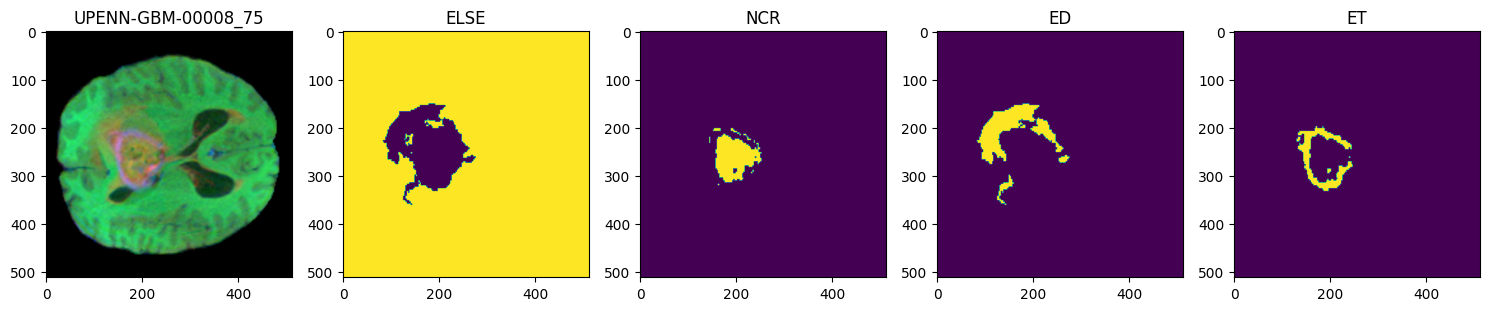

In [30]:
# Visualize input data
true_img = {}

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"{test_subj}")

for mask_idx, label in enumerate(test_class_labels):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    label_id = label.item()
    true_img[label_id] = img
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[label_id]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()


In [31]:
# load one batch of data and make predictions

model.to(device)

model.eval()
with torch.no_grad():
    outputs = model(
            pixel_values=test_image.unsqueeze(0).to(device),
            mask_labels=[test_mask_label.to(device)],
            class_labels=[test_class_labels.to(device)],
        )

torch.cuda.empty_cache()

# post-processing of output
target_size = transforms.ToPILImage()(test_image).size[::-1]
# target_size = (163, 193)
results = processor.post_process_instance_segmentation(outputs, target_sizes=[target_size])[0]

print(results['segments_info'])
print(test_image.shape)
print(results['segmentation'].shape)

[{'id': 0, 'label_id': 0, 'was_fused': False, 'score': 0.99242}, {'id': 1, 'label_id': 2, 'was_fused': False, 'score': 0.889586}, {'id': 2, 'label_id': 3, 'was_fused': False, 'score': 0.900965}, {'id': 3, 'label_id': 1, 'was_fused': False, 'score': 0.944047}]
torch.Size([3, 512, 512])
torch.Size([512, 512])


In [32]:
# Obtain labels in true, predict, intersection and union

labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )
# remove duplicates
labels_pred = list(set(labels_pred))

labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'NCR', 'ED', 'ET']
Predicted labels: ['ELSE', 'NCR', 'ET', 'ED']
All labels: ['ELSE', 'ED', 'NCR', 'ET']
Common labels: ['ELSE', 'NCR', 'ET', 'ED']


Visualizing mask for instance: ELSE
label_id is: 0
Visualizing mask for instance: NCR
label_id is: 1
Visualizing mask for instance: ED
label_id is: 2
Visualizing mask for instance: ET
label_id is: 3


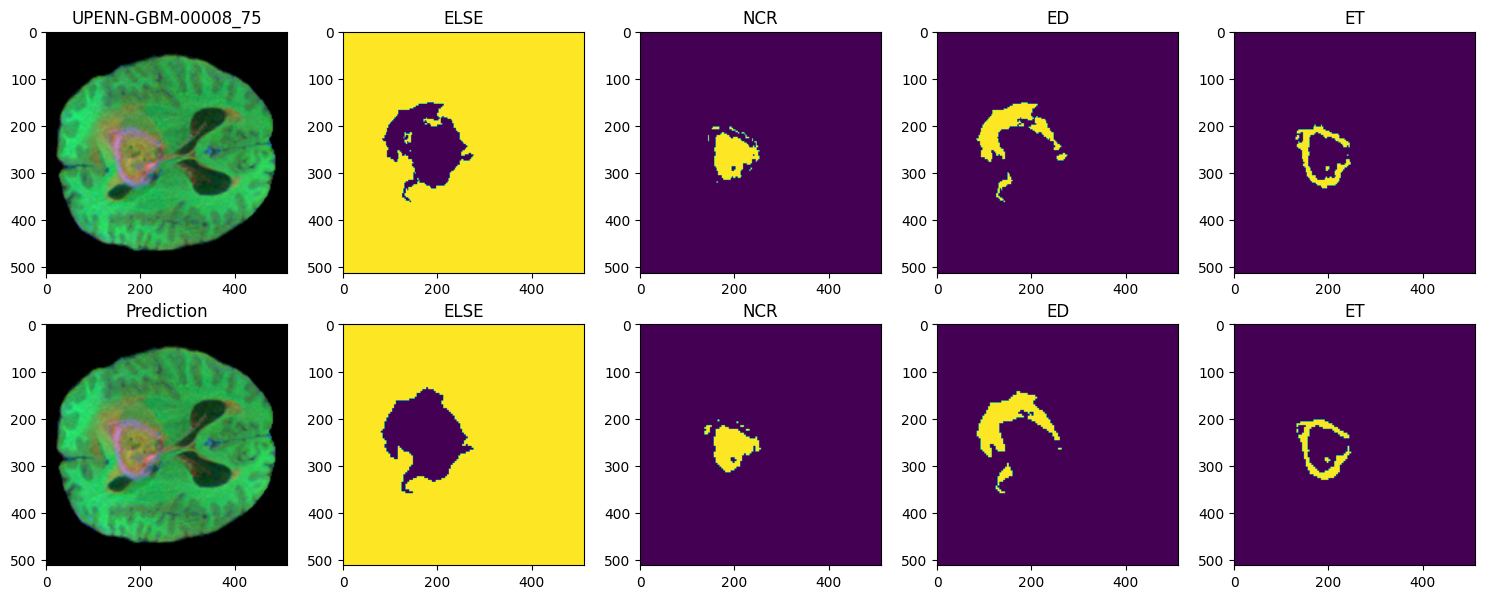

In [33]:
# visual QC predicted masks

n_image = len(id2label)+1
id_list = list(id2label.keys())
id_list.sort()

mask_preds = {}

fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid
mask_pred = np.zeros((len(id_list)))
for mask_idx, id in enumerate(id_list):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[0,mask_idx+1].imshow(img)
    axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

for mask_idx, id in enumerate(id_list):
    mask_pred = np.zeros((results['segmentation'].shape[0],results['segmentation'].shape[1]))

    # find information in results
    for item in results['segments_info']:
        if item['label_id'] == id:
            segment = item
            mask_pred += np.array( get_mask(results['segmentation'], segment['id']) )

    mask_pred = mask_pred.astype(np.uint8)
    mask_preds[id] = mask_pred

    label = id2label[id]
    print("Visualizing mask for instance:", label)
    print("label_id is:", id )

    axs[1,mask_idx+1].imshow(mask_pred)
    axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0,0].imshow(unnormalized_image)
axs[0,0].set_title(f"{test_subj}")

axs[1,0].imshow(unnormalized_image)
axs[1,0].set_title(f"Prediction")

plt.tight_layout()
plt.show()

#### 4.1.2 Visualization of model output (Optional)

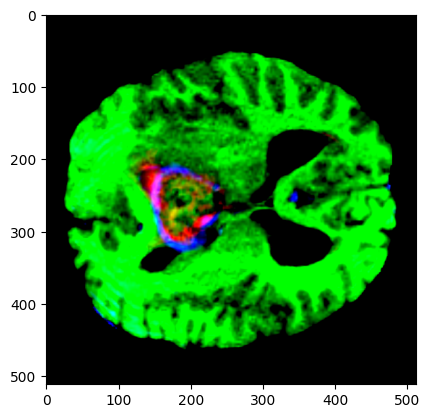

In [ ]:
# display first image
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([1, 100, 5])
masks_queries_logits shape: torch.Size([1, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([1, 1024, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([1, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([1, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([1, 8, 100, 100])


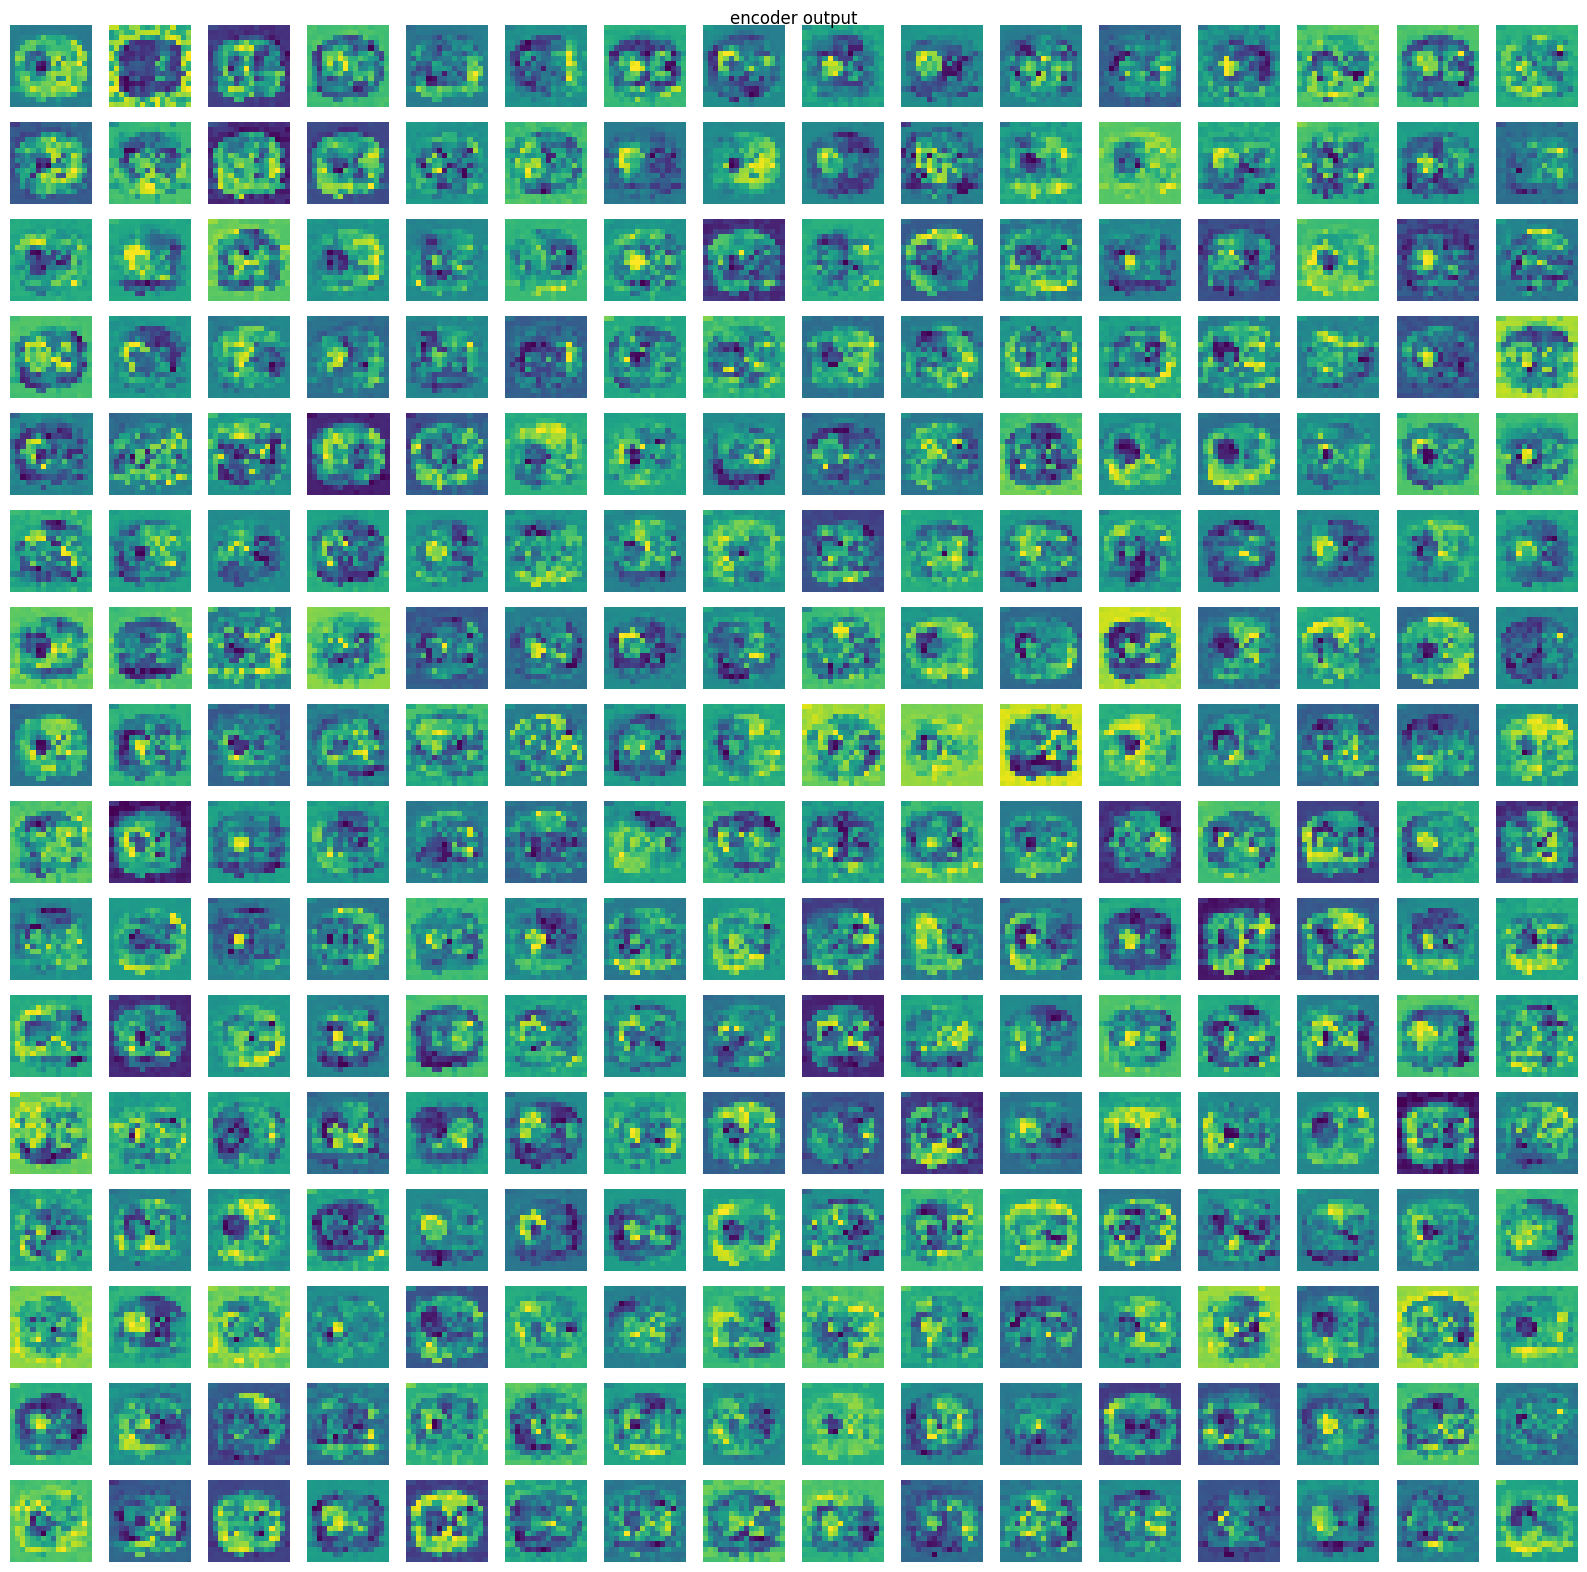

In [ ]:
# visualize the last layer of the encoder

n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

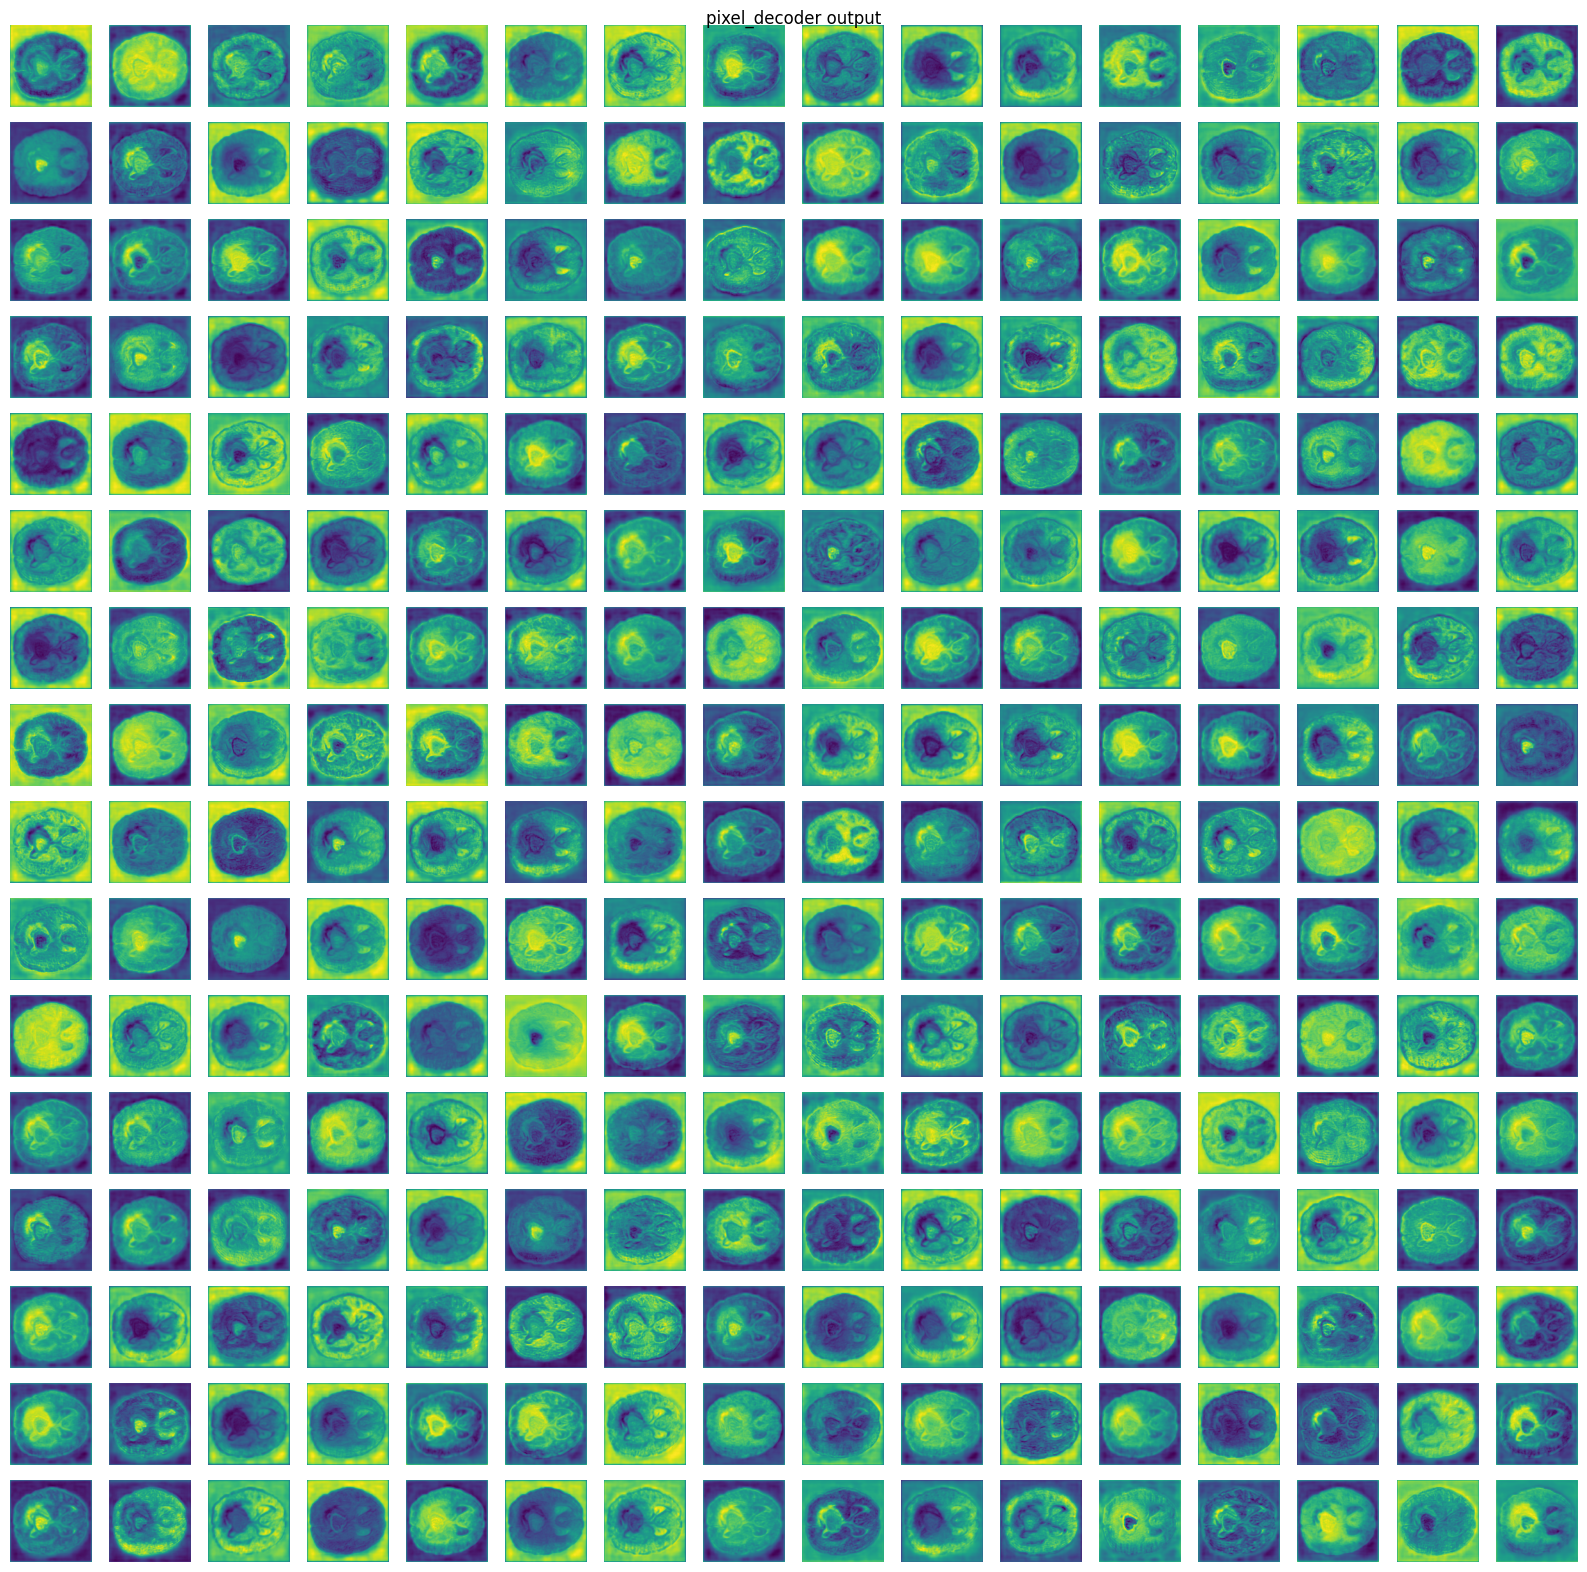

In [ ]:
# visualize the last layer of the pixel decodeer

n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

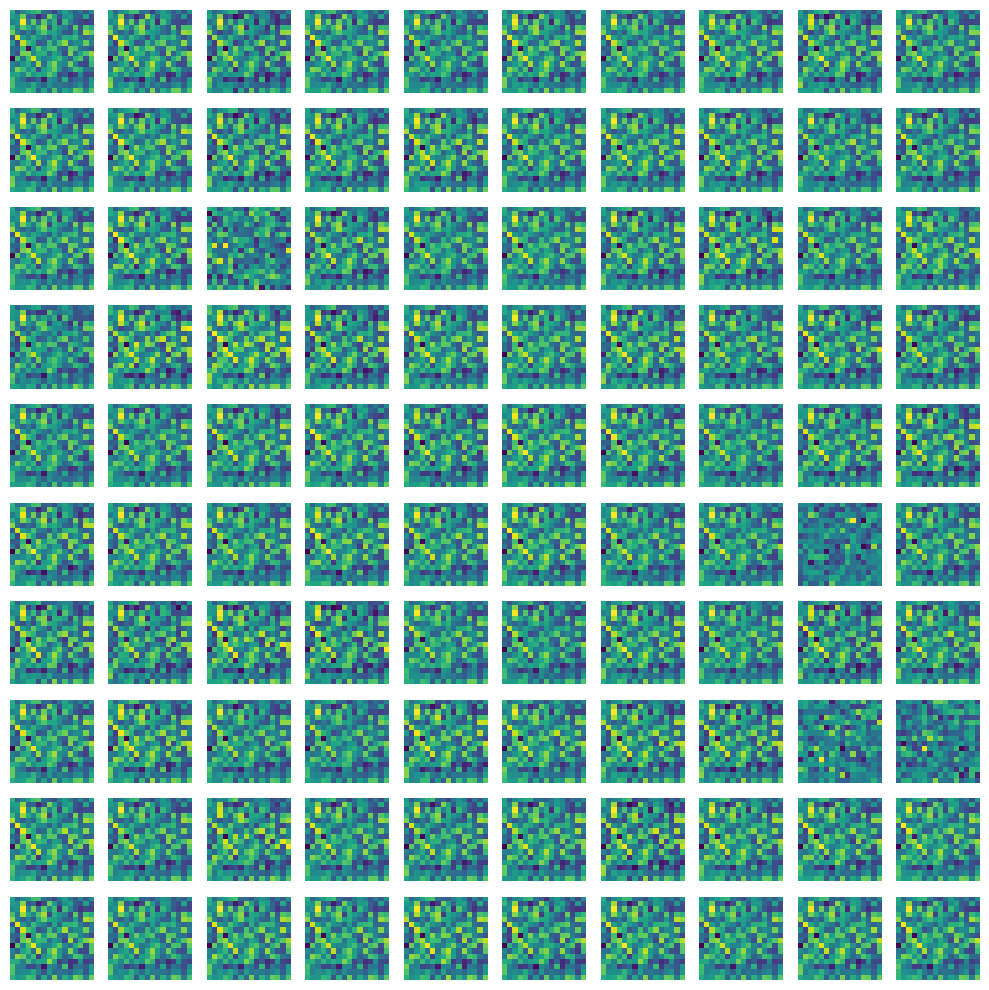

In [ ]:
# visualize the last layer of the transformer decodeer

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        decoder_last_test =  outputs.transformer_decoder_last_hidden_state[0,idx,:].detach().cpu().numpy().reshape((16,16))
        axs[irow,icol].imshow(decoder_last_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

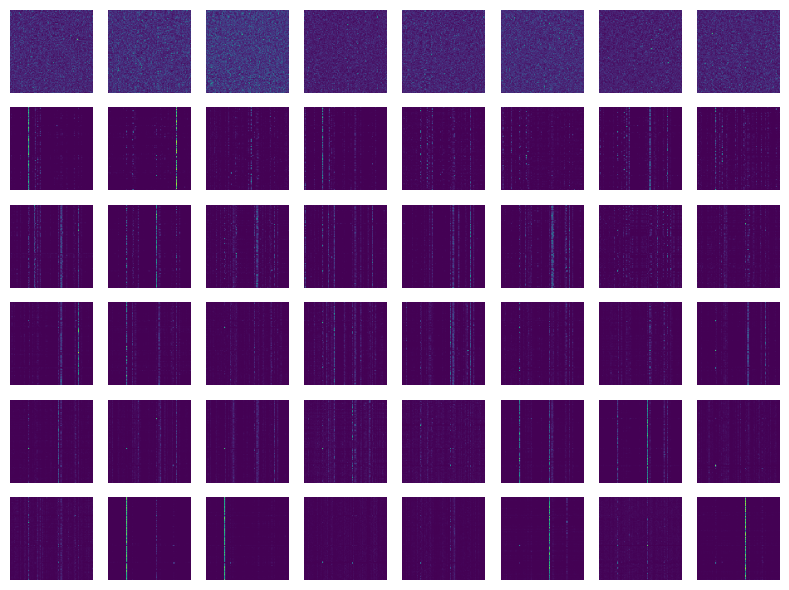

In [ ]:
#visualize the attention map

n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

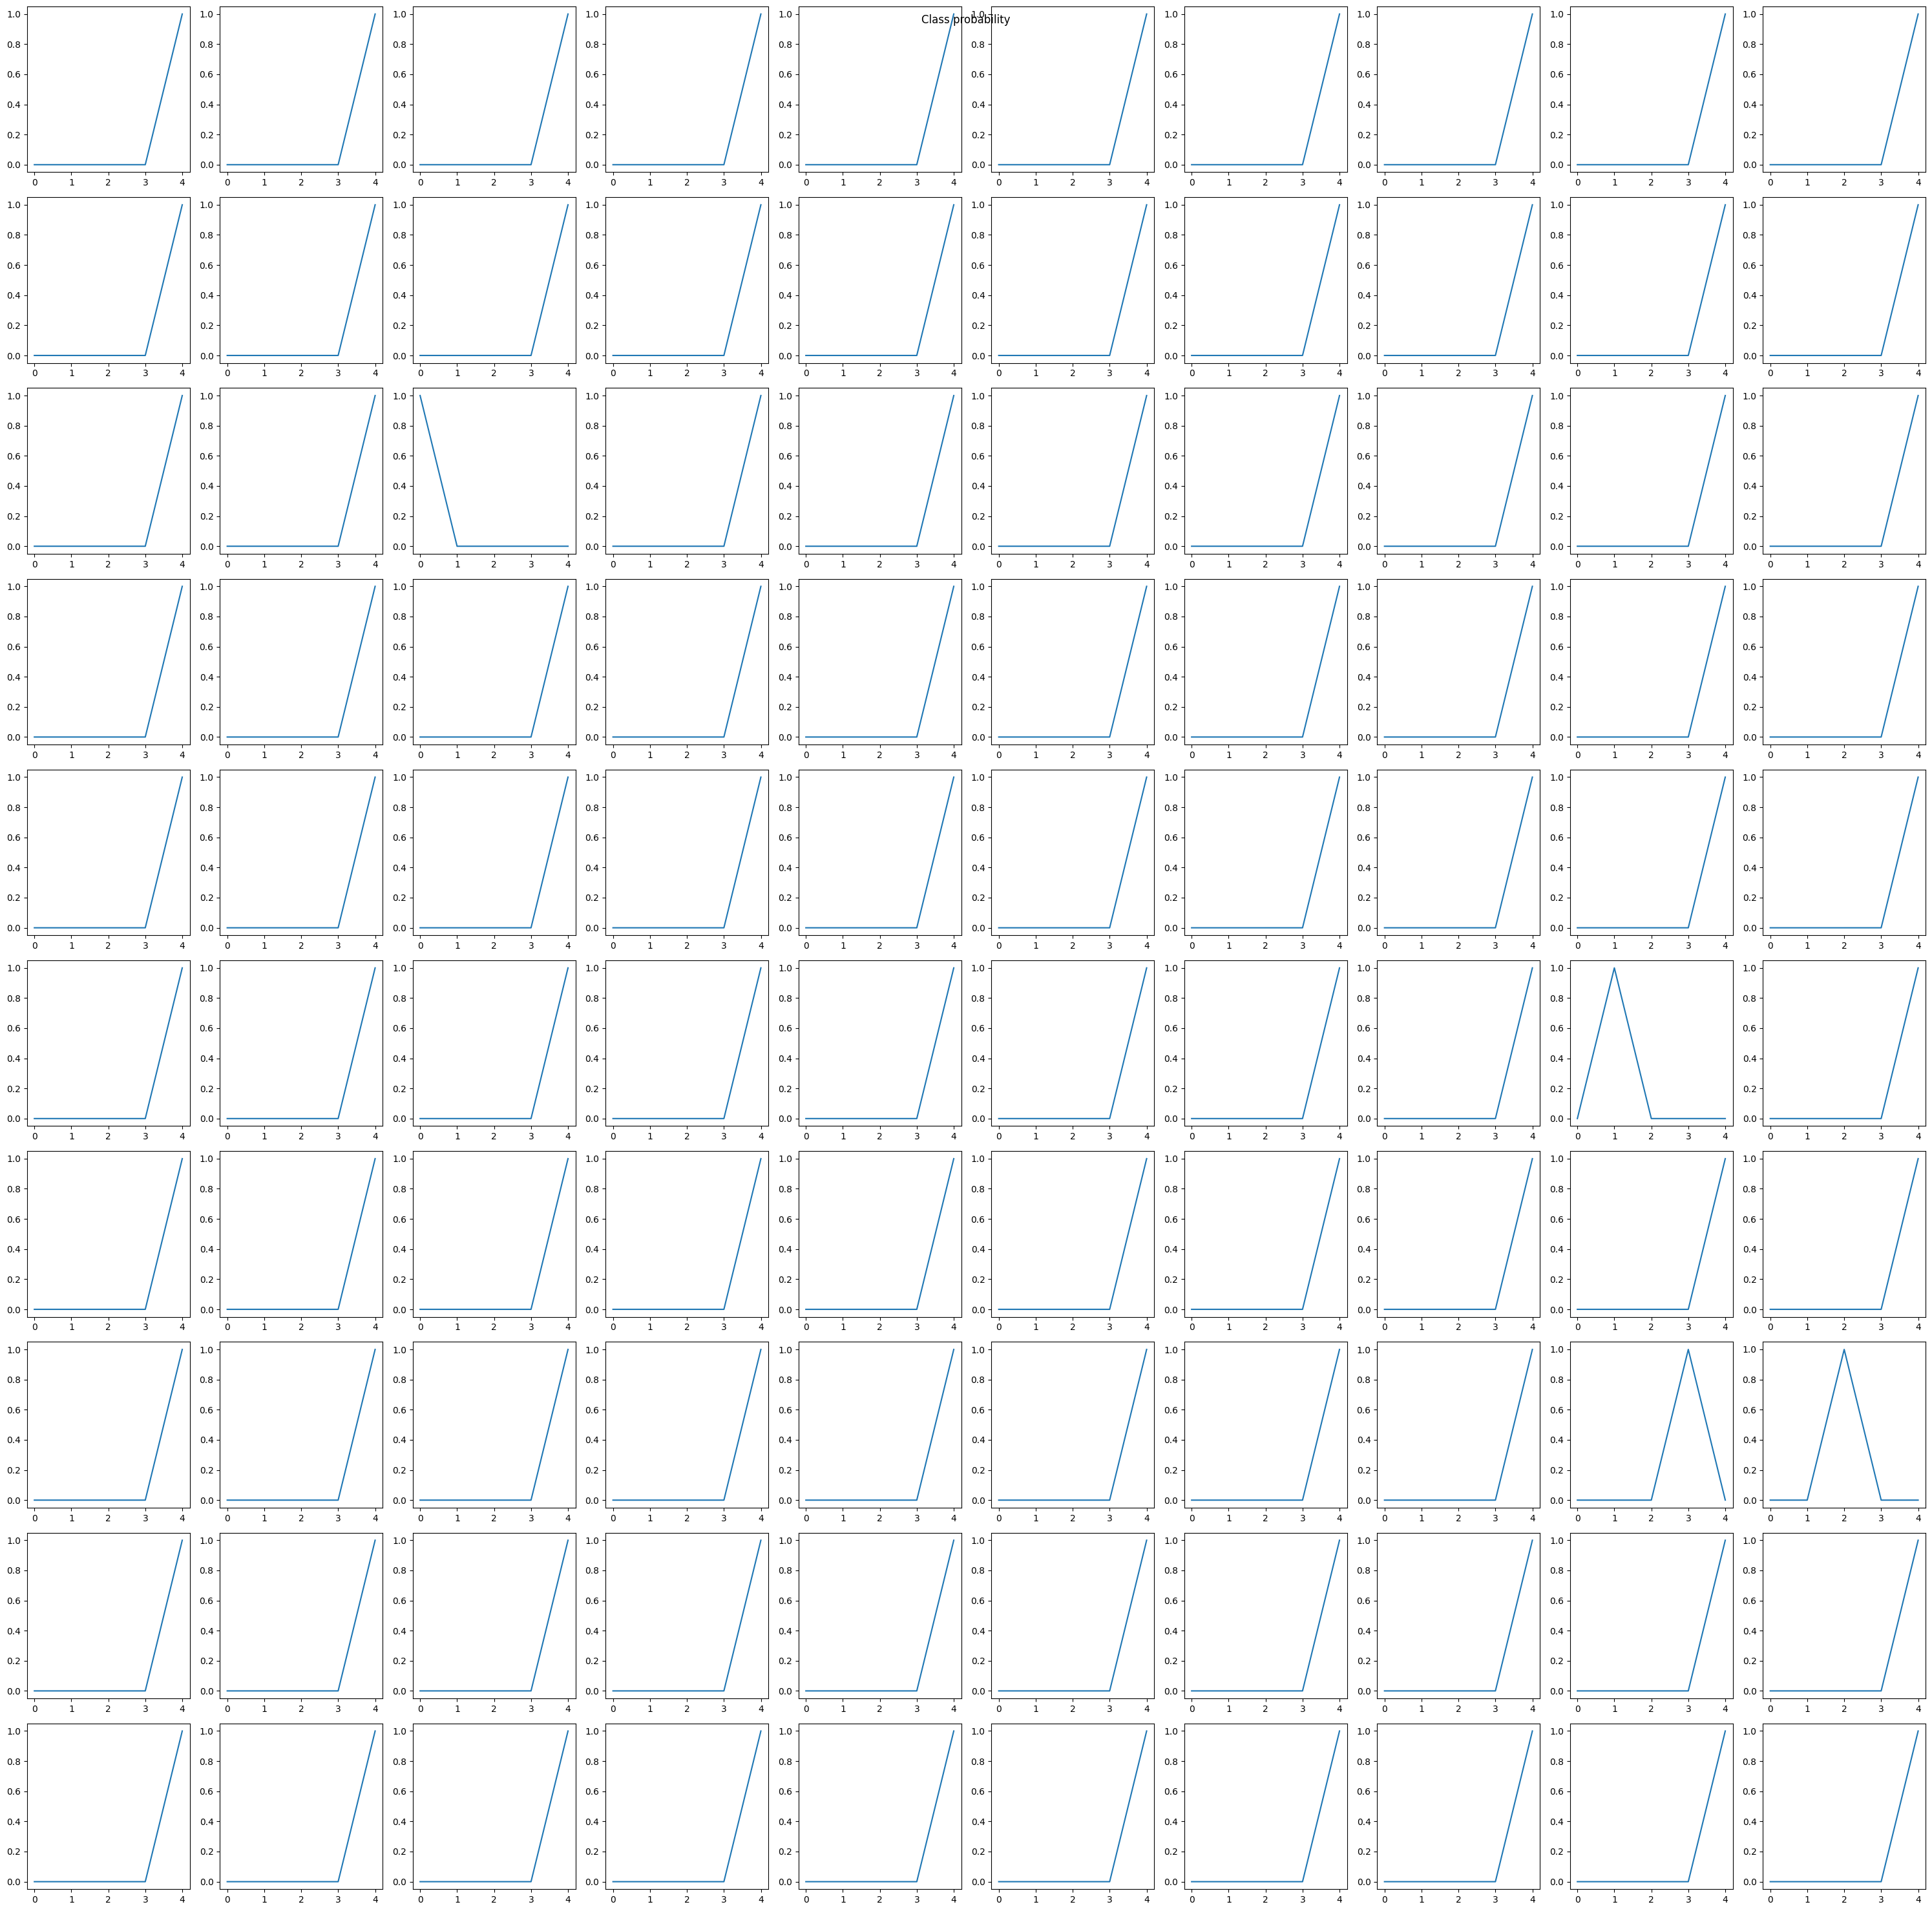

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation

img_size = outputs.pixel_decoder_last_hidden_state.shape[-1]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_size*img_size)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_size, img_size).numpy()

mask_pred_vis.shape

(100, 128, 128)

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

torch.Size([256, 16384])
torch.Size([100, 256])


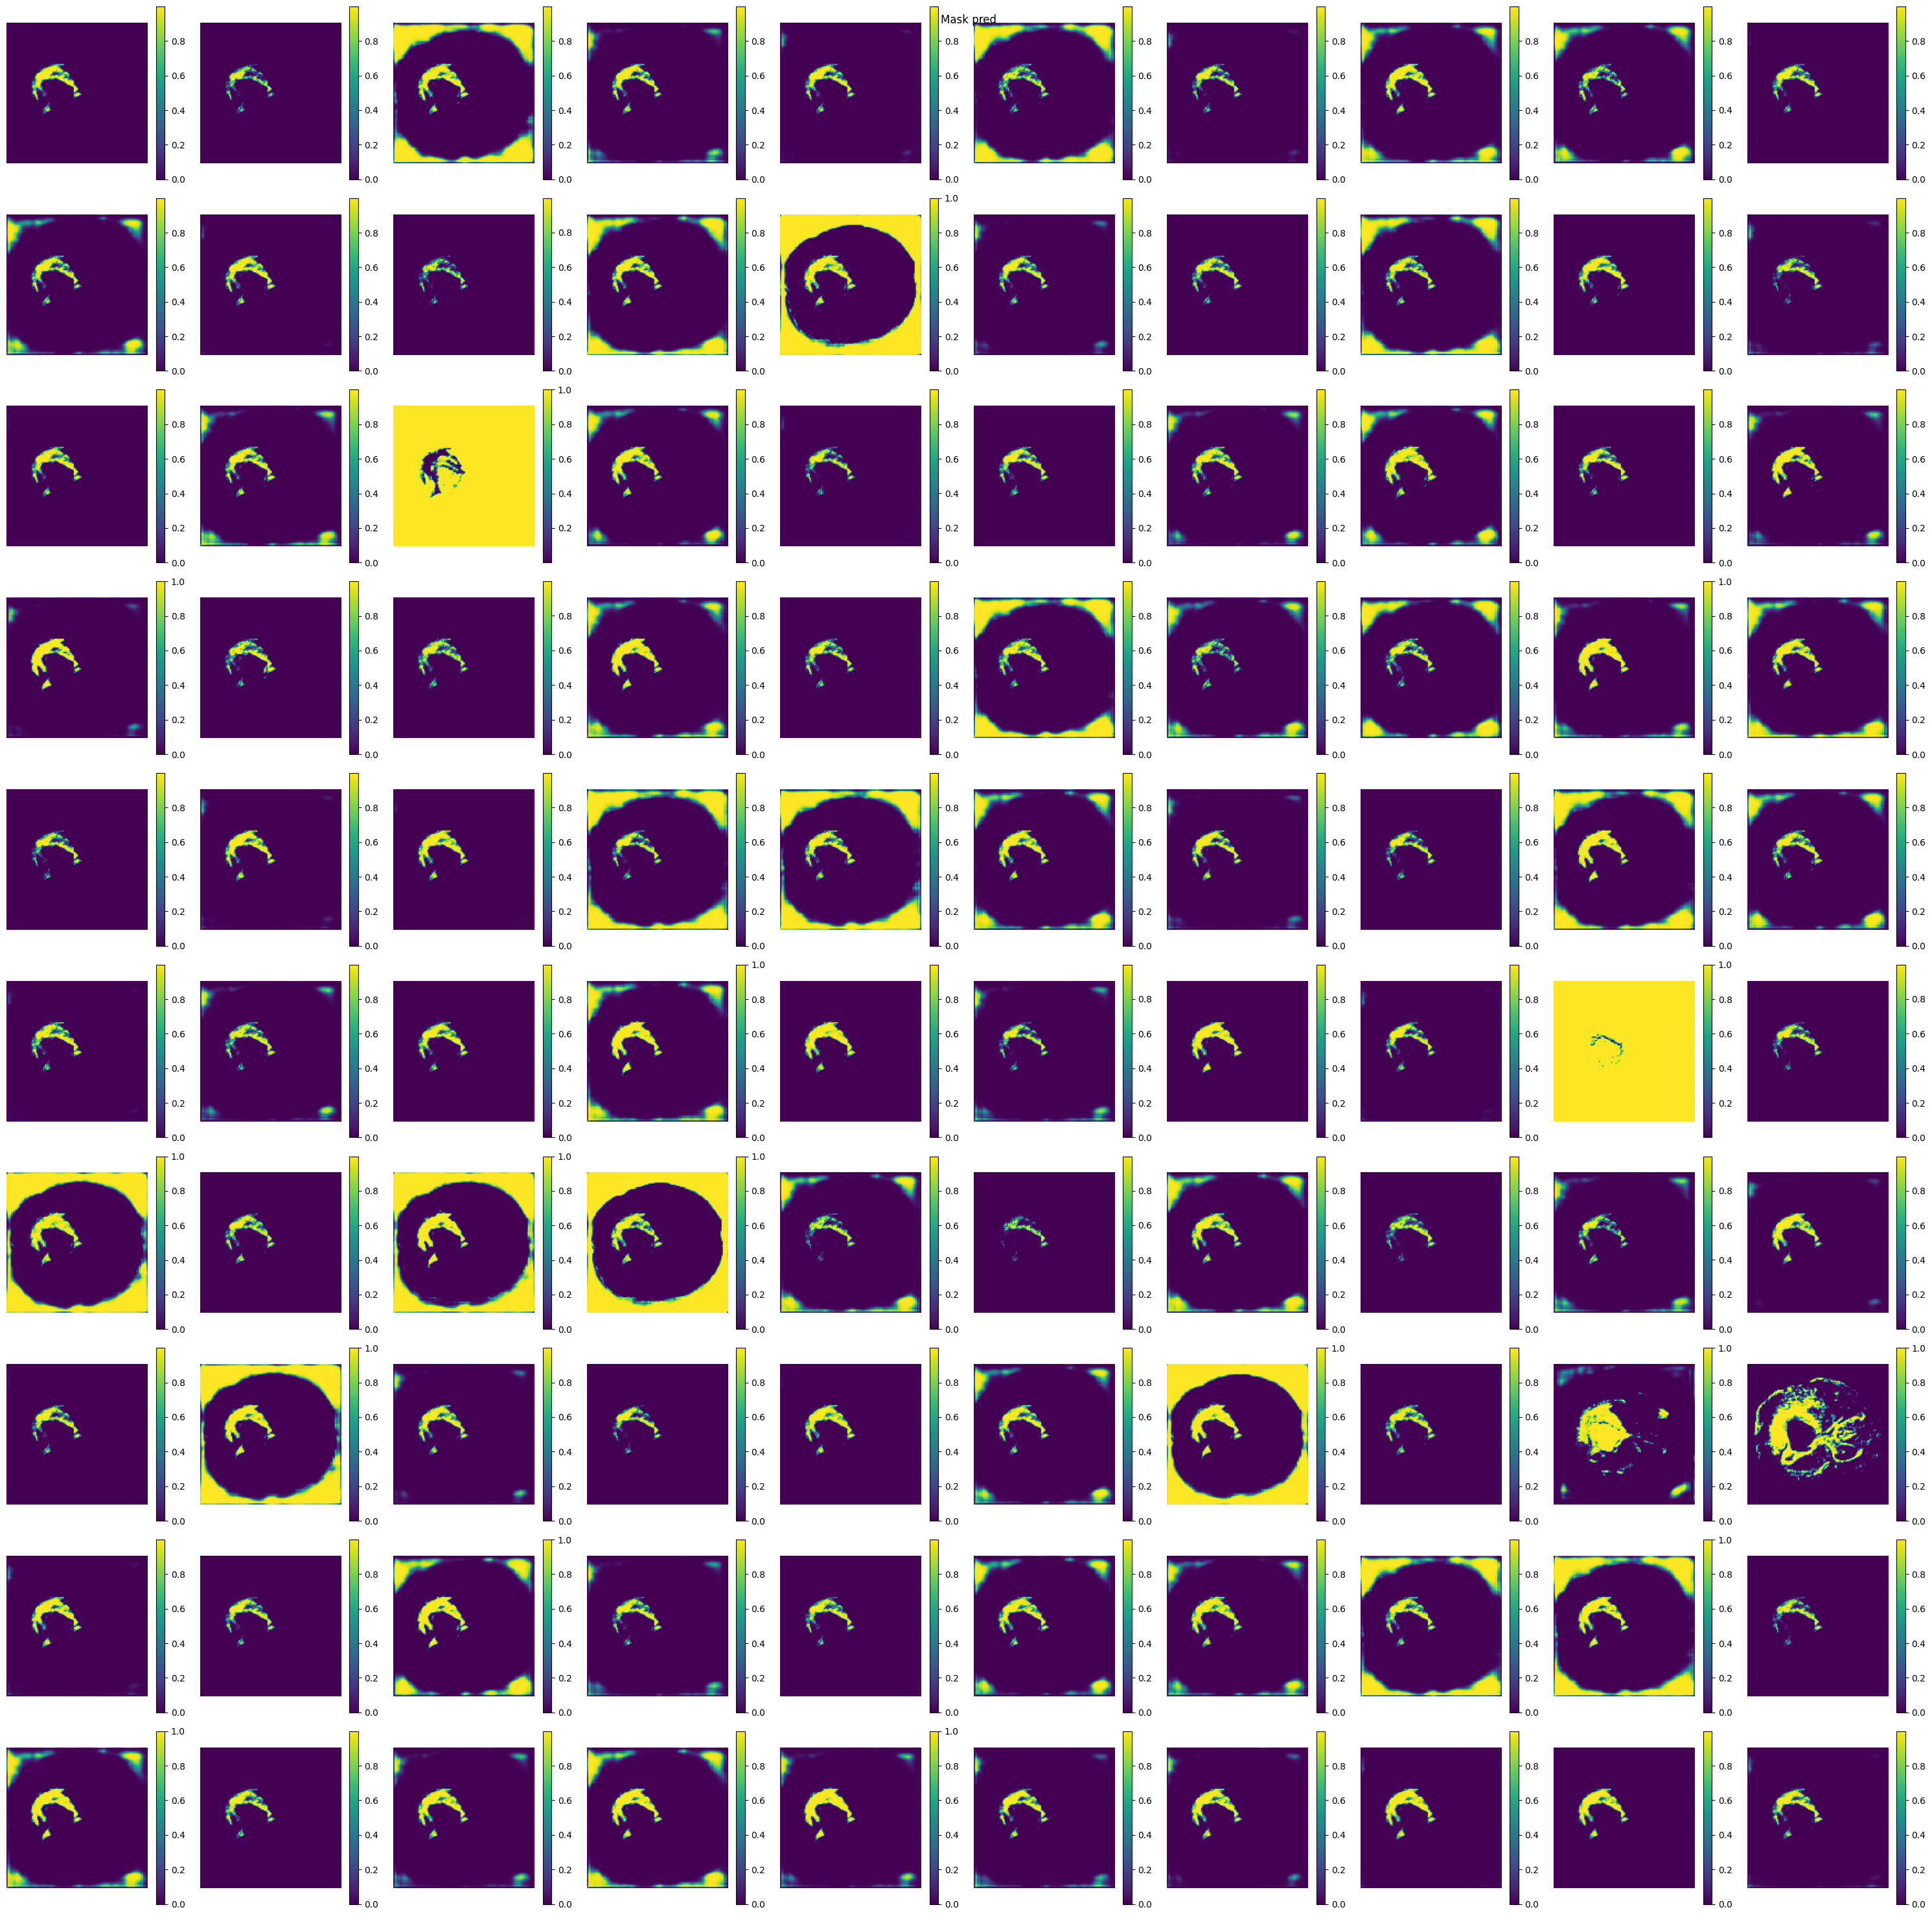

In [ ]:
# visualize mask prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


In [ ]:
print('shape of class probability is:',class_probs.shape)
print('shape of predicted mask is:',mask_pred.shape)

shape of class probability is: (100, 5)
shape of predicted mask is: (512, 512)


torch.Size([128, 128])


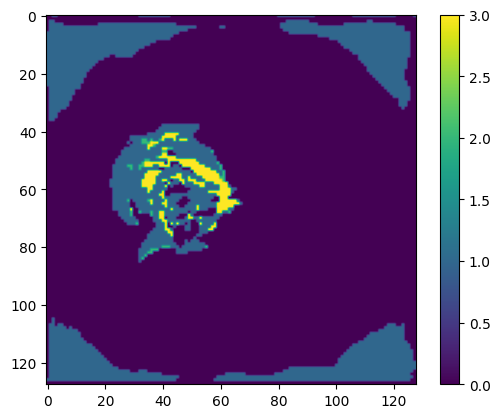

In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_size*img_size)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_size,img_size)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()

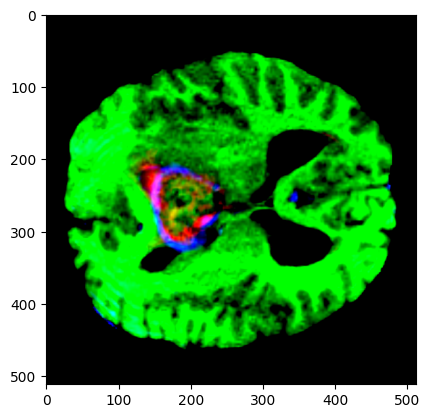

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)

#### 4.1.3 Calcualte metrics on one sample

In [34]:
true_img.items()

dict_items([(0, <PIL.Image.Image image mode=L size=512x512 at 0x7F7AD57BA410>), (1, <PIL.Image.Image image mode=L size=512x512 at 0x7F7AD57A46A0>), (2, <PIL.Image.Image image mode=L size=512x512 at 0x7F7AD5798700>), (3, <PIL.Image.Image image mode=L size=512x512 at 0x7F7AD57851E0>)])

In [35]:
for label_id, true_mask_pil in true_img.items():
  print(f"Metrics for {id2label[label_id]}:")
  true_mask = (np.array(true_mask_pil)/255).astype(np.uint8)
  if label_id in mask_preds:
    pred_mask_pil = mask_preds[label_id]
    pred_mask = (np.array(pred_mask_pil)/255).astype(np.uint8)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)

    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

  else:
    print(f"Segment {id2label[label_id]} does not exist in prediction")

  print("")
  # calc_binary_metrics(segm_pred, segm_true, segm_id)

Metrics for ELSE:
Specificity 0.9924891622139329
Sensitivity 0.9855760897377696
Precision 0.9993764646802812
Recall 0.9855760897377696
Dice Score 0.9924283036823711
HD95 11.0

Metrics for NCR:
Specificity 0.9980951039869825
Sensitivity 0.8917835671342685
Precision 0.9223533163265306
Recall 0.8917835671342685
Dice Score 0.9068108785955012
HD95 8.06225774829855

Metrics for ED:
Specificity 0.9931992938639622
Sensitivity 0.931841074426413
Precision 0.8286226114649682
Recall 0.931841074426413
Dice Score 0.8772059210872887
HD95 6.0

Metrics for ET:
Specificity 0.9977185249565433
Sensitivity 0.8523550724637681
Precision 0.8648897058823529
Recall 0.8523550724637681
Dice Score 0.8585766423357665
HD95 3.0



### 4.2 make predictions on all data and compute metrics

#### 4.2.0 functions used in computing metrics

In [69]:
def get_slices_for_subj(file_list, subj):
    # if substring/subj is in the filename, include that file in the list of slices
    vol_list = [file_name for file_name in file_list if subj in file_name]

    # sort the list according to slice number
    vol_list_sorted = sorted(vol_list, key=lambda x: int(x.split('_')[1].split('.')[0]))
    return vol_list_sorted

In [68]:
# create arrays to hold 3d volumes
def predict_data(model, data_handler, vol_slices_list, processor, transform, identifier=MriType.VAL_2D):
    mask_pred_3d = np.zeros((len(id_list), 146, 512, 512), dtype=np.uint8)
    mask_true_3d = np.zeros((len(id_list), 146, 512, 512), dtype=np.uint8)
    image_3d = np.zeros((146, 3, 512, 512), dtype=np.uint8)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # define a new dataset
    metric_dataset = CustomMRIDataset(data_handler=data_handler, data_identifier=identifier,
                                            data_list=vol_slices_list, processor=processor,
                                            transform=transform, augment=False)
    batch_size_metrics = 1

    # define data loader
    metric_dataloader = DataLoader(metric_dataset, batch_size=batch_size_metrics,
                                      shuffle=False, collate_fn=collate_fn)

    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(metric_dataloader):

            # forward pass
            output_cur = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # post-processing of output
            # get first item in batch where batch size = 1
            image_cur = batch["pixel_values"][0]
            image_3d[ibatch, :, :, :] = image_cur.numpy()

            result_cur = processor.post_process_instance_segmentation(output_cur,
                                                                      target_sizes=[transforms.ToPILImage()(image_cur).size[::-1]])[0]

            # obtain predicted_mask
            for mask_idx, id in enumerate(id_list):
                # 512x512
                mask_pred_cur = np.zeros((result_cur['segmentation'].shape[0], result_cur['segmentation'].shape[1]))

                # find predicted masks in results
                for item in result_cur['segments_info']:
                    # get label id from segments_info
                    if item['label_id'] == id:
                        segment = item
                        mask_pred_cur += np.array( get_mask(result_cur['segmentation'], segment['id']) )

                mask_pred_cur = mask_pred_cur.astype(np.uint8)
                mask_pred_3d[mask_idx, ibatch, :, :] = mask_pred_cur

            # obtain true mask where available
            # [4, 512, 512]
            mask_labels_cur = batch["mask_labels"][0]
            class_label_cur = batch["class_labels"][0]
            for idx in range(mask_labels_cur.shape[0]):
                label_idx = class_label_cur[idx].item()
                mask_true_3d[label_idx, ibatch, :, :] = (mask_labels_cur[idx,:,:].bool().numpy() * 255).astype(np.uint8)

    return image_3d, mask_true_3d, mask_pred_3d

In [67]:
def calc_metric_all_segments(label_ids, metric_func, mask_pred_3d, mask_true_3d):
    results = []
    for label_id in label_ids:
      true_mask_cur = mask_true_3d[label_id,:,:,:].squeeze()
      pred_mask_cur = mask_pred_3d[label_id,:,:,:].squeeze()
      result = metric_func(pred_mask_cur, true_mask_cur)
      results.append(result)
    return results

In [66]:
def display_statistics(metric_scores, metric_name, label_names):
    print("Summary:", metric_name)
    df = pd.DataFrame(metric_scores, columns=label_names)
    print(df.describe())

In [65]:
def draw_box_plot(metric_scores, metric_name, label_names, ax, set_ylim=False):
  sns.boxplot(data=metric_scores,  palette="turbo", ax=ax)
  ax.set_xticks(range(len(label_names)), label_names)
  ax.set_ylabel("score")
  ax.set_title(metric_name)
  if set_ylim:
    ax.set_ylim(0, 1.02)

#### 4.2.1 obtain data list for all validation data

In [36]:
# Create a new list of files from the full val list dataset
val_list_test = data_handler.load_text_as_list(file_name=val_list_full, train_dir_prefix=train_dir_prefix)

# get_mri_slice_file_name function:
# file_name: UPENN-GBM-00006_11_FLAIR_1.nii.gz
# result: UPENN-GBM-00006_1.nii.gz
validation_files = list(set([data_handler.get_mri_slice_file_name(val_file) for val_file in val_list_test]))
validation_files[:10]

['UPENN-GBM-00474_74.nii.gz',
 'UPENN-GBM-00013_114.nii.gz',
 'UPENN-GBM-00140_0.nii.gz',
 'UPENN-GBM-00033_105.nii.gz',
 'UPENN-GBM-00439_108.nii.gz',
 'UPENN-GBM-00474_47.nii.gz',
 'UPENN-GBM-00054_120.nii.gz',
 'UPENN-GBM-00261_7.nii.gz',
 'UPENN-GBM-00206_103.nii.gz',
 'UPENN-GBM-00261_4.nii.gz']

In [37]:
# get unique subj_ids
validation_subjs = [data_handler.get_mri_subj(val_file) for val_file in validation_files]
validation_subjs = sorted(list(set(validation_subjs)))

print("total validation data", len(validation_subjs))

print("first 10")
validation_subjs[:10]

total validation data 30
first 10


['UPENN-GBM-00008',
 'UPENN-GBM-00013',
 'UPENN-GBM-00020',
 'UPENN-GBM-00030',
 'UPENN-GBM-00033',
 'UPENN-GBM-00054',
 'UPENN-GBM-00075',
 'UPENN-GBM-00086',
 'UPENN-GBM-00100',
 'UPENN-GBM-00101']

#### 4.2.2. make predictions on all validation data

In [38]:
id_list = list(id2label.keys())
id_list

[0, 1, 2, 3]

In [41]:
all_dice = []
all_hd95 = []
all_common_metrics = []
error_files = []

In [ ]:
# predict all validation data
start = time.time()

val_subjs_selected = validation_subjs[:]

image_3d, mask_true_3d, mask_pred_3d = None, None, None
for val_subj in val_subjs_selected:
    print("Calculating metrics for ", val_subj)
    vol_slices_list = get_slices_for_subj(validation_files, val_subj)

    image_3d, mask_true_3d, mask_pred_3d = predict_data(model, data_handler, vol_slices_list,
                                                        processor, train_transform, MriType.VAL_2D)

    mask_pred_3d_binary = (np.array(mask_pred_3d)/255).astype(np.uint8)
    mask_true_3d_binary = (np.array(mask_true_3d)/255).astype(np.uint8)

    try:
        # common metrics
        common_metrics = calc_metric_all_segments(id_list, metrics.calc_binary_metrics,
                                                  mask_pred_3d_binary, mask_true_3d_binary)
        common_metrics_dict = {}
        for key in common_metrics[0]:
          common_metrics_dict[key] = [metric[key] for metric in common_metrics]

        # dice coefficient
        dice_score = calc_metric_all_segments(id_list, metrics.calc_dice_score,
                                              mask_pred_3d_binary, mask_true_3d_binary)

        # 95% Hausdorff
        hausdorff = calc_metric_all_segments(id_list, metrics.calc_hausdorff_95,
                                                 mask_pred_3d_binary, mask_true_3d_binary)

        if hausdorff is None or hausdorff_val == np.inf:
          raise Exception(f"Error calculating hausroff: {val_subj}")

        # append only when there is no error:
        all_dice.append(dice_score)
        all_hd95.append(hausdorff)
        all_common_metrics.append(common_metrics_dict)

    except Exception as ex:
        print(f"Error {val_subj}", ex)
        error_files.append(val_subj)

end = time.time()
print("elapsed time", str(end - start))

#### 4.2.3 Save/Load/Visualize validation statistics

In [71]:
# load or save statistics
variables_dict = {}

RECALCULATE_METRICS = False
# metrics_file_name = f"metrics-{str(int( time.time() ))}.joblib"
metrics_file_name = f"metrics_val_all_aug_20epoch.joblib"
metrics_dir_prefix = "maskformer/huafeng"

if RECALCULATE_METRICS:
    scores_file = "validation_metrics.joblib"

    print("errors", error_files)
    success_val_files = list(filter(lambda x: x not in error_files, validation_subjs))

    print(f"New length after removing problematic images: {len(success_val_files)}")
    success_val_files_np = np.array(success_val_files)

    variables_dict = {'success_val_files': success_val_files,
                      'success_val_files_np': success_val_files_np,
                      'error_files': error_files,
                      'all_dice': all_dice,
                      'all_hd95': all_hd95,
                      'all_common_metrics': all_common_metrics}

    # dump data to temp file
    metrics_temp_file = data_handler.create_temp_file(metrics_file_name)
    joblib.dump(variables_dict, metrics_temp_file)

    # upload to cloud
    data_handler.save_from_source_path(file_name=metrics_file_name, source_path=metrics_temp_file,
                                      train_dir_prefix=metrics_dir_prefix, use_cloud=True)
else:
    metrics_temp_file = data_handler.load_to_temp_file(file_name=metrics_file_name,
                                                       train_dir_prefix=metrics_dir_prefix)

    variables_dict = joblib.load(metrics_temp_file)

In [72]:
all_label_names = list(id2label.values())

In [73]:
success_val_files = variables_dict["success_val_files"]
success_val_files_np = variables_dict["success_val_files_np"]
error_files = variables_dict["error_files"]
all_dice = variables_dict["all_dice"]
all_hd95 = variables_dict["all_hd95"]
all_common_metrics = variables_dict["all_common_metrics"]

In [74]:
metrics_dict = {
    "precision": np.array([metric['precision'] for metric in all_common_metrics]),
    "recall": np.array([metric['recall'] for metric in all_common_metrics]),
    "sensitivity": np.array([metric['sensitivity'] for metric in all_common_metrics]),
    "specificity": np.array([metric['specificity'] for metric in all_common_metrics]),
    "dice_score": np.array(all_dice),
    "hd95": np.array(all_hd95)
}

In [75]:
for key, np_val in metrics_dict.items():
  display_statistics(np_val, key, all_label_names)
  print("\n")

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.999520   0.779725   0.899845   0.841648
std     0.000249   0.152259   0.043401   0.074851
min     0.998908   0.296053   0.774501   0.637844
25%     0.999347   0.732087   0.872260   0.802435
50%     0.999559   0.798633   0.915270   0.857264
75%     0.999701   0.905100   0.932336   0.890261
max     0.999841   0.943332   0.954365   0.972158


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.997297   0.780938   0.882137   0.823625
std     0.001345   0.099923   0.037859   0.060859
min     0.993857   0.484988   0.778685   0.651652
25%     0.996424   0.729040   0.868972   0.799343
50%     0.997635   0.784283   0.886032   0.830723
75%     0.998269   0.851180   0.908205   0.864275
max     0.999407   0.933481   0.936820   0.918452


Summary: sensitivity
            ELSE        NCR         ED  

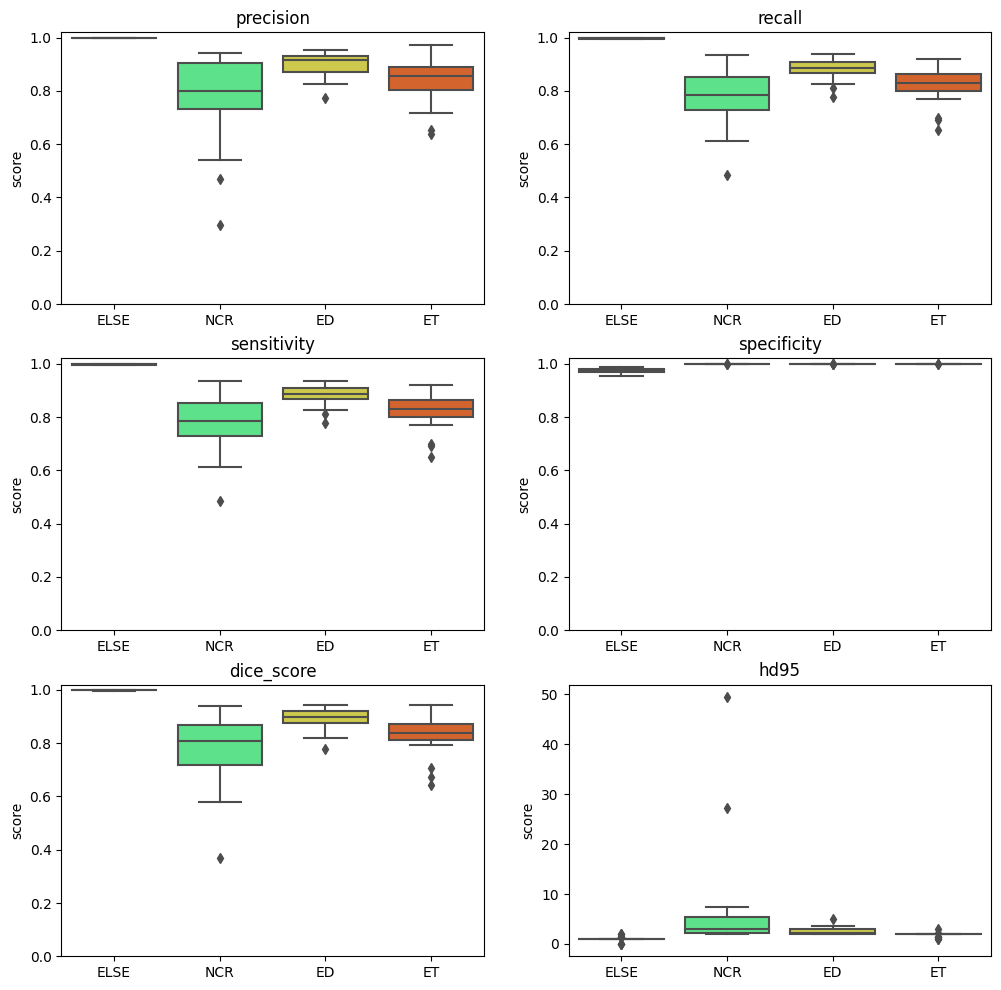

In [77]:
nrows = 3
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

count = 0
for key, np_val in metrics_dict.items():
  row = count//ncols
  col = count%ncols
  ax = axs[row, col]
  if key != "hd95":
    draw_box_plot(np_val, key, all_label_names, ax, set_ylim=True)
  else:
    draw_box_plot(np_val, key, all_label_names, ax, set_ylim=False)
  count+=1

plt.show()

#### 4.2.4 QC 3D volume by slicing in 3 directions (optional)

In [ ]:
# QC one slice of the 3D volumes (image, true and prediction)

n_image = len(id2label)+1
id_list = list(id2label.keys())
id_list.sort()

slice_no = 100

fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

mask_pred = np.zeros((len(id_list)))

for mask_idx, id in enumerate(id_list):
    mask_cur = mask_true_3d[mask_idx, slice_no,:,:]
    img = Image.fromarray(mask_cur)

    im = axs[0,mask_idx+1].imshow(img)
    axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot
    cbar = fig.colorbar(im, ax=axs[0, mask_idx + 1], pad=0.05, fraction=0.05)

    label = id2label[id]
    print("Visualizing mask for instance:", label)
    print("label_id is:", id )

    mask_cur = mask_pred_3d[mask_idx, slice_no,:,:]

    im = axs[1,mask_idx+1].imshow(mask_cur)
    axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot
    cbar = fig.colorbar(im, ax=axs[1, mask_idx + 1], pad=0.05, fraction=0.05)

unnormalized_image = ( image_3d[slice_no,:,:,:] * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0,0].imshow(unnormalized_image)
# axs[0,0].set_title(f"{success_val_files[-1]}")

axs[1,0].imshow(unnormalized_image)
axs[1,0].set_title(f"Image")

plt.tight_layout()
plt.show()

In [ ]:
# QC one slice of the 3D volumes (image, true and prediction)

n_image = len(id2label)+1
id_list = list(id2label.keys())
id_list.sort()

slice_no = 360

fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

mask_pred = np.zeros((len(id_list)))

for mask_idx, id in enumerate(id_list):
    mask_cur = mask_true_3d[mask_idx,:,slice_no,:]
    img = Image.fromarray(mask_cur)
    im = axs[0,mask_idx+1].imshow(img)
    axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot
    cbar = fig.colorbar(im, ax=axs[0, mask_idx + 1], pad=0.05, fraction=0.05)

    label = id2label[id]
    print("Visualizing mask for instance:", label)
    print("label_id is:", id )

    mask_cur = mask_pred_3d[mask_idx,:,slice_no,:]
    im = axs[1,mask_idx+1].imshow(mask_cur)
    axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot
    cbar = fig.colorbar(im, ax=axs[1, mask_idx + 1], pad=0.05, fraction=0.05)

unnormalized_image = ( image_3d[:,:,slice_no,:] * np.array(ADE_STD)[None,:,None] ) + np.array(ADE_MEAN)[None,:,None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 1, -1)

axs[0,0].imshow(unnormalized_image)
axs[0,0].set_title(f"Image")

axs[1,0].imshow(unnormalized_image)
axs[1,0].set_title(f"Image")

plt.tight_layout()
plt.show()

In [ ]:
# QC one slice of the 3D volumes (image, true and prediction)

# n_image = len(id2label)+1
# id_list = list(id2label.keys())
# id_list.sort()

# slice_no = 200

# fig, axs = plt.subplots(nrows=2, ncols=n_image, figsize=(3*n_image, 3*2))  # Create subplots grid

# mask_pred = np.zeros((len(id_list)))

# for mask_idx, id in enumerate(id_list):
#     mask_cur = mask_true_3d[mask_idx,:,:,slice_no]
#     img = Image.fromarray(mask_cur)
#     axs[0,mask_idx+1].imshow(img)
#     axs[0,mask_idx+1].set_title(f"{id2label[id]}")  # Set a title for the subplot

#     label = id2label[id]
#     print("Visualizing mask for instance:", label)
#     print("label_id is:", id )

#     mask_cur = mask_pred_3d[mask_idx,:,:,slice_no]
#     axs[1,mask_idx+1].imshow(mask_cur)
#     axs[1,mask_idx+1].set_title(f"{label}")  # Set a title for the subplot

# unnormalized_image = ( image_3d[:,:,:,slice_no] * np.array(ADE_STD)[None,:,None] ) + np.array(ADE_MEAN)[None,:,None]
# unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 1, -1)

# axs[0,0].imshow(unnormalized_image)
# axs[0,0].set_title(f"Image")

# axs[1,0].imshow(unnormalized_image)
# axs[1,0].set_title(f"Image")

# plt.tight_layout()
# plt.show()

#### 4.2.5 obtain data list for all training data

In [49]:
# Create a new list of files from the full val list dataset
train_list_test = data_handler.load_text_as_list(file_name=train_list_full, train_dir_prefix=train_dir_prefix)

# get_mri_slice_file_name function:
# file_name: UPENN-GBM-00006_11_FLAIR_1.nii.gz
# result: UPENN-GBM-00006_1.nii.gz
train_files = list(set([data_handler.get_mri_slice_file_name(train_file) for train_file in train_list_test]))
train_files[:10]

['UPENN-GBM-00066_49.nii.gz',
 'UPENN-GBM-00006_19.nii.gz',
 'UPENN-GBM-00312_68.nii.gz',
 'UPENN-GBM-00139_126.nii.gz',
 'UPENN-GBM-00060_50.nii.gz',
 'UPENN-GBM-00376_84.nii.gz',
 'UPENN-GBM-00307_43.nii.gz',
 'UPENN-GBM-00375_60.nii.gz',
 'UPENN-GBM-00428_73.nii.gz',
 'UPENN-GBM-00226_72.nii.gz']

In [50]:
# get unique subj_ids
train_subjs = [data_handler.get_mri_subj(train_file) for train_file in train_files]
train_subjs = sorted(list(set(train_subjs)))

print("total training data", len(train_subjs))

print("first 10")
train_subjs[:10]

total training data 88
first 10


['UPENN-GBM-00006',
 'UPENN-GBM-00009',
 'UPENN-GBM-00011',
 'UPENN-GBM-00016',
 'UPENN-GBM-00017',
 'UPENN-GBM-00018',
 'UPENN-GBM-00021',
 'UPENN-GBM-00029',
 'UPENN-GBM-00031',
 'UPENN-GBM-00035']

#### 4.2.6. make predictions on all training data

In [51]:
all_dice = []
all_hd95 = []
all_common_metrics = []
error_files = []

In [56]:
# predict all training data
start = time.time()

train_subjs_selected = train_subjs[:]

image_3d, mask_true_3d, mask_pred_3d = None, None, None
for train_subj in train_subjs_selected:
    print("Calculating metrics for ", train_subj)
    vol_slices_list = get_slices_for_subj(train_files, train_subj)

    image_3d, mask_true_3d, mask_pred_3d = predict_data(model, data_handler, vol_slices_list,
                                                        processor, train_transform, MriType.TRAIN_2D)

    mask_pred_3d_binary = (np.array(mask_pred_3d)/255).astype(np.uint8)
    mask_true_3d_binary = (np.array(mask_true_3d)/255).astype(np.uint8)

    try:
        # common metrics
        common_metrics = calc_metric_all_segments(id_list, metrics.calc_binary_metrics,
                                                  mask_pred_3d_binary, mask_true_3d_binary)
        common_metrics_dict = {}
        for key in common_metrics[0]:
          common_metrics_dict[key] = [metric[key] for metric in common_metrics]

        # dice coefficient
        dice_score = calc_metric_all_segments(id_list, metrics.calc_dice_score,
                                              mask_pred_3d_binary, mask_true_3d_binary)

        # 95% Hausdorff
        hausdorff = calc_metric_all_segments(id_list, metrics.calc_hausdorff_95,
                                                 mask_pred_3d_binary, mask_true_3d_binary)

        if hausdorff is None or hausdorff == np.inf:
          raise Exception(f"Error calculating hausroff: {train_subj}")

        # append only when there is no error:
        all_dice.append(dice_score)
        all_hd95.append(hausdorff)
        all_common_metrics.append(common_metrics_dict)

    except Exception as ex:
        print(f"Error {train_subj}", ex)
        error_files.append(train_subj)

end = time.time()
print("elapsed time", str(end - start))

Calculating metrics for  UPENN-GBM-00006
Calculating metrics for  UPENN-GBM-00009
Calculating metrics for  UPENN-GBM-00011
Calculating metrics for  UPENN-GBM-00016
Calculating metrics for  UPENN-GBM-00017
Calculating metrics for  UPENN-GBM-00018
Calculating metrics for  UPENN-GBM-00021
Calculating metrics for  UPENN-GBM-00029
Calculating metrics for  UPENN-GBM-00031
Calculating metrics for  UPENN-GBM-00035
Calculating metrics for  UPENN-GBM-00040
Calculating metrics for  UPENN-GBM-00041
Calculating metrics for  UPENN-GBM-00043
Calculating metrics for  UPENN-GBM-00060
Calculating metrics for  UPENN-GBM-00066
Calculating metrics for  UPENN-GBM-00069
Calculating metrics for  UPENN-GBM-00073
Calculating metrics for  UPENN-GBM-00076
Calculating metrics for  UPENN-GBM-00080
Calculating metrics for  UPENN-GBM-00082
Calculating metrics for  UPENN-GBM-00083
Calculating metrics for  UPENN-GBM-00088
Calculating metrics for  UPENN-GBM-00091
Calculating metrics for  UPENN-GBM-00093
Calculating metr

#### 4.2.7 Save/Load/Visualize validation statistics

In [57]:
# load or save statistics
variables_dict = {}

RECALCULATE_METRICS = True
metrics_file_name = f"metrics-{str(int( time.time() ))}.joblib"
metrics_dir_prefix = "maskformer/huafeng"

if RECALCULATE_METRICS:
    scores_file = "training_metrics.joblib"

    print("errors", error_files)
    success_train_files = list(filter(lambda x: x not in error_files, train_subjs))

    print(f"New length after removing problematic images: {len(success_train_files)}")
    success_train_files_np = np.array(success_train_files)

    variables_dict = {'success_train_files': success_train_files,
                      'success_train_files_np': success_train_files_np,
                      'error_files': error_files,
                      'all_dice': all_dice,
                      'all_hd95': all_hd95,
                      'all_common_metrics': all_common_metrics}

    # dump data to temp file
    metrics_temp_file = data_handler.create_temp_file(metrics_file_name)
    joblib.dump(variables_dict, metrics_temp_file)

    # upload to cloud
    data_handler.save_from_source_path(file_name=metrics_file_name, source_path=metrics_temp_file,
                                      train_dir_prefix=metrics_dir_prefix, use_cloud=True)
else:
    metrics_temp_file = data_handler.load_to_temp_file(file_name=metrics_file_name,
                                                       train_dir_prefix=metrics_dir_prefix)

    variables_dict = joblib.load(metrics_temp_file)

errors []
New length after removing problematic images: 88


In [58]:
all_label_names = list(id2label.values())

In [60]:
success_train_files = variables_dict["success_train_files"]
success_train_files_np = variables_dict["success_train_files_np"]
error_files = variables_dict["error_files"]
all_dice = variables_dict["all_dice"]
all_hd95 = variables_dict["all_hd95"]
all_common_metrics = variables_dict["all_common_metrics"]

In [61]:
metrics_dict = {
    "precision": np.array([metric['precision'] for metric in all_common_metrics]),
    "recall": np.array([metric['recall'] for metric in all_common_metrics]),
    "sensitivity": np.array([metric['sensitivity'] for metric in all_common_metrics]),
    "specificity": np.array([metric['specificity'] for metric in all_common_metrics]),
    "dice_score": np.array(all_dice),
    "hd95": np.array(all_hd95)
}

In [62]:
for key, np_val in metrics_dict.items():
  display_statistics(np_val, key, all_label_names)
  print("\n")

Summary: precision
            ELSE        NCR         ED         ET
count  88.000000  88.000000  88.000000  88.000000
mean    0.999535   0.794512   0.878596   0.849308
std     0.000259   0.161321   0.077743   0.059619
min     0.998673   0.000000   0.523367   0.637844
25%     0.999434   0.754077   0.856231   0.816850
50%     0.999566   0.832695   0.893894   0.861018
75%     0.999707   0.904702   0.930325   0.887587
max     0.999944   0.960183   0.961559   0.972158


Summary: recall
            ELSE        NCR         ED         ET
count  88.000000  88.000000  88.000000  88.000000
mean    0.997428   0.784475   0.869389   0.827717
std     0.001303   0.121773   0.056618   0.058030
min     0.993479   0.000000   0.557622   0.607696
25%     0.996592   0.750183   0.850049   0.799731
50%     0.997767   0.808702   0.879476   0.840037
75%     0.998324   0.849172   0.904757   0.867405
max     0.999453   0.933481   0.936820   0.918452


Summary: sensitivity
            ELSE        NCR         ED  

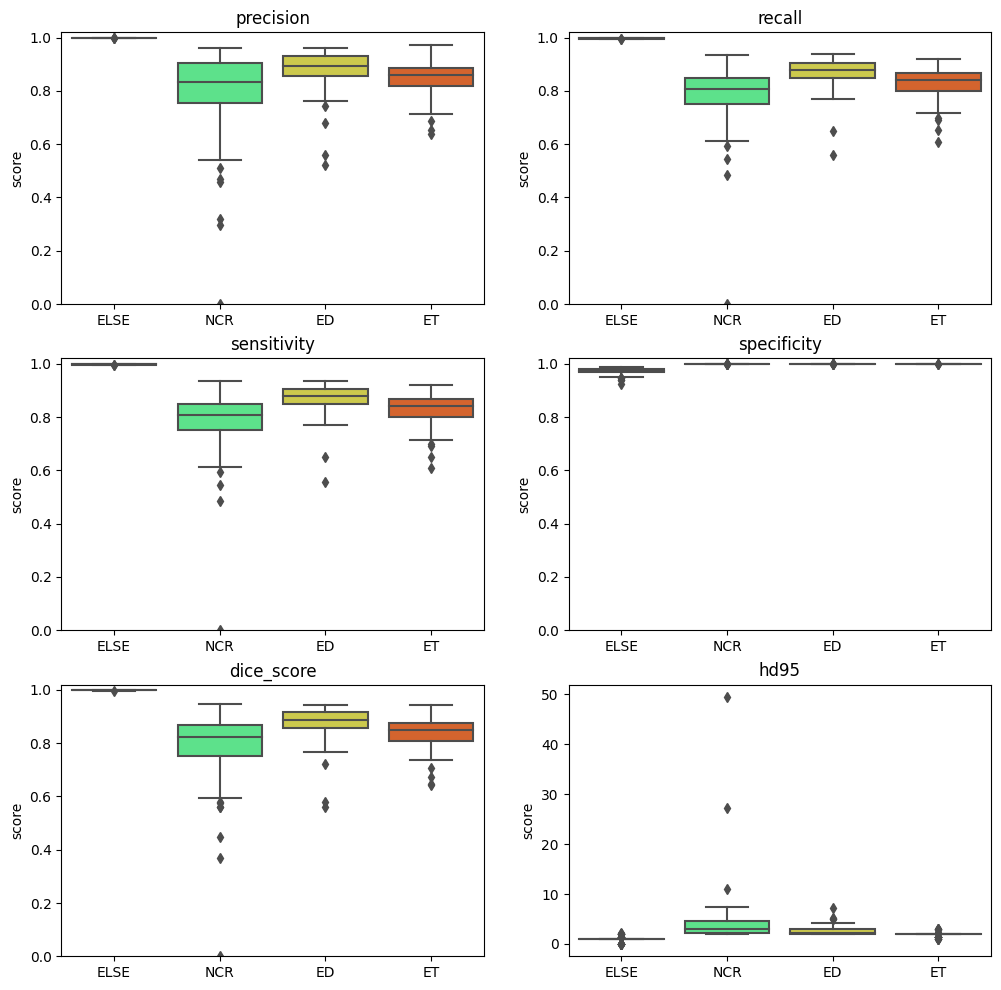

In [70]:
nrows = 3
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

count = 0
for key, np_val in metrics_dict.items():
  row = count//ncols
  col = count%ncols
  ax = axs[row, col]
  if key != "hd95":
    draw_box_plot(np_val, key, all_label_names, ax, set_ylim=True)
  else:
    draw_box_plot(np_val, key, all_label_names, ax, set_ylim=False)
  count+=1

plt.show()

## Back-up